### Fine-tuning SpeechT5

Now that you are familiar with the text-to-speech task and internal workings of the SpeechT5 model that was pre-trained on English language data, let’s see how we can fine-tune it to another language.

You’ll also need some additional dependencies:

In [46]:
#!pip install transformers datasets soundfile speechbrain accelerate

Finally, don’t forget to log in to your Hugging Face account so that you could upload and share your model with the community:

In [47]:
from huggingface_hub import notebook_login
notebook_login()

**The dataset**

For this example we’ll take the Dutch (nl) language subset of the VoxPopuli dataset. VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages. While we will be using the Dutch language subset, feel free to pick another subset.

This is an automated speech recognition (ASR) dataset, so, as mentioned before, it is not the most suitable option for training TTS models. However, it will be good enough for this exercise.

Let’s load the data:

In [48]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/multilingual_librispeech", "portuguese", split="train")
len(dataset)

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

37533

In [49]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

**Preprocessing the data**

Let’s begin by defining the model checkpoint to use and loading the appropriate processor that contains both tokenizer, and feature extractor that we will need to prepare the data for training:

In [50]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

**Text cleanup for SpeechT5 tokenization**

First, for preparing the text, we’ll need the tokenizer part of the processor, so let’s get it:

In [51]:
tokenizer = processor.tokenizer

In [52]:
#Let’s take a look at an example:
dataset[0]

{'audio': {'path': '12249_10229_000000.opus',
  'array': array([-0.00026572, -0.0002681 , -0.0002242 , ...,  0.00018133,
          0.00024239,  0.00040742]),
  'sampling_rate': 16000},
 'original_path': 'http://www.archive.org/download/canaa_1901_librivox/canaa_12_aranha_64kb.mp3',
 'begin_time': 617.09,
 'end_time': 635.04,
 'transcript': 'e quando ia sendo arrebatado pela expansão dos seus mais íntimos anceios maciel conteve-se com esforço ficou repentinamente mudo fitando com os olhos vermelhos e húmidos o extrangeiro',
 'audio_duration': 17.949999999999932,
 'speaker_id': '12249',
 'chapter_id': '10229',
 'file': '12249_10229_000000.opus',
 'id': '12249_10229_000000'}

What you may notice is that the dataset examples contain *transcript* feature. When deciding which feature to use as the text input, it will be important to know that the SpeechT5 tokenizer doesn’t have any tokens for numbers. In normalized_text the numbers are written out as text. Thus, it is a better fit, and we should use normalized_text as input text.

Because SpeechT5 was trained on the English language, it may not recognize certain characters in the Dutch dataset. If left as is, these characters will be converted to <unk> tokens. However, in Dutch, certain characters like à are used to stress syllables. In order to preserve the meaning of the text, we can replace this character with a regular a.

To identify unsupported tokens, extract all unique characters in the dataset using the SpeechT5Tokenizer which works with characters as tokens. To do this, we’ll write the extract_all_chars mapping function that concatenates the transcriptions from all examples into one string and converts it to a set of characters. Make sure to set batched=True and batch_size=-1 in dataset.map() so that all transcriptions are available at once for the mapping function.

In [53]:
def extract_all_chars(batch):
    all_text = " ".join(batch["transcript"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/37533 [00:00<?, ? examples/s]

Now you have two sets of characters: one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. To identify any unsupported characters in the dataset, you can take the difference between these two sets. The resulting set will contain the characters that are in the dataset but not in the tokenizer.

In [54]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'á', 'â', 'ã', 'ç', 'í', 'ò', 'ó', 'ô', 'õ', 'ú', 'ü'}

To handle the unsupported characters identified in the previous step, we can define a function that maps these characters to valid tokens. Note that spaces are already replaced by ▁ in the tokenizer and don’t need to be handled separately.

In [55]:
replacements = [
    ("à", "a"),
    ("á", "a"),
    ("ã", "a"),
    ("ã", "a"),
    ("ç", "c"),
    ("í", "i"),
    ("ò", "o"),
    ("ó", "o"),
    ("ô", "o"),
    ("õ", "o"),
    ("ú", "u"),
    ("ü", "u")
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["transcript"] = inputs["transcript"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

In [56]:
dataset[0]

{'audio': {'path': '12249_10229_000000.opus',
  'array': array([-0.00026572, -0.0002681 , -0.0002242 , ...,  0.00018133,
          0.00024239,  0.00040742]),
  'sampling_rate': 16000},
 'original_path': 'http://www.archive.org/download/canaa_1901_librivox/canaa_12_aranha_64kb.mp3',
 'begin_time': 617.09,
 'end_time': 635.04,
 'transcript': 'e quando ia sendo arrebatado pela expansao dos seus mais intimos anceios maciel conteve-se com esforco ficou repentinamente mudo fitando com os olhos vermelhos e humidos o extrangeiro',
 'audio_duration': 17.949999999999932,
 'speaker_id': '12249',
 'chapter_id': '10229',
 'file': '12249_10229_000000.opus',
 'id': '12249_10229_000000'}

Now that we have dealt with special characters in the text, it’s time to shift the focus to the audio data.

**Speakers**

The VoxPopuli dataset includes speech from multiple speakers, but how many speakers are represented in the dataset? To determine this, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset. With a total of 20,968 examples in the dataset, this information will give us a better understanding of the distribution of speakers and examples in the data.

In [57]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram you can get a sense of how much data there is for each speaker.

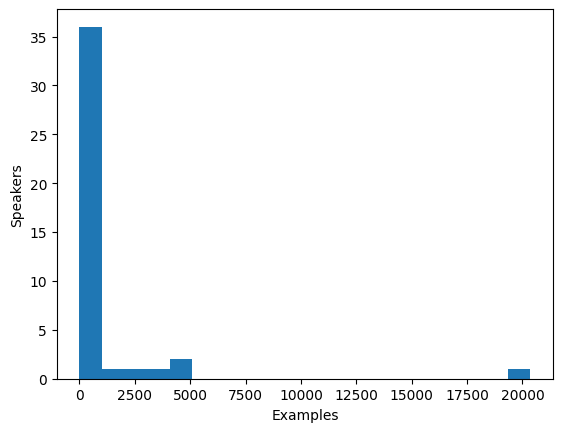

In [58]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while around ten speakers have more than 500 examples. To improve training efficiency and balance the dataset, we can limit the data to speakers with between 100 and 400 examples.

In [59]:
def select_speaker(speaker_id):
    return 2000 <= speaker_counts[speaker_id] <= 5000

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/37533 [00:00<?, ? examples/s]

Let’s check how many speakers remain:

In [60]:
len(set(dataset["speaker_id"]))

5

Let’s see how many examples are left:

In [61]:
len(dataset)

16601

You are left with just under 16,000 examples from approximately 5 unique speakers, which should be sufficient.

Note that some speakers with few examples may actually have more audio available if the examples are long. However, determining the total amount of audio for each speaker requires scanning through the entire dataset, which is a time-consuming process that involves loading and decoding each audio file. As such, we have chosen to skip this step here.

**Speaker embeddings**

To enable the TTS model to differentiate between multiple speakers, you’ll need to create a speaker embedding for each example. The speaker embedding is an additional input into the model that captures a particular speaker’s voice characteristics. To generate these speaker embeddings, use the pre-trained spkrec-xvect-voxceleb model from SpeechBrain.

Create a function create_speaker_embedding() that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [62]:
#!pip install speechbrain

In [63]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"

speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /tmp/speechbrain/spkrec-xvect-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ck

It’s important to note that the speechbrain/spkrec-xvect-voxceleb model was trained on English speech from the VoxCeleb dataset, whereas the training examples in this guide are in Dutch. While we believe that this model will still generate reasonable speaker embeddings for our Dutch dataset, this assumption may not hold true in all cases.

For optimal results, we would need to train an X-vector model on the target speech first. This will ensure that the model is better able to capture the unique voice characteristics present in the Dutch language. If you’d like to train your own X-vector model, you can use this script as an example.

**Processing the dataset**

Finally, let’s process the data into the format the model expects. Create a prepare_dataset function that takes in a single example and uses the SpeechT5Processor object to tokenize the input text and load the target audio into a log-mel spectrogram. It should also add the speaker embeddings as an additional input.

In [64]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["transcript"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Verify the processing is correct by looking at a single example:

In [65]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

Speaker embeddings should be a 512-element vector:

In [66]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

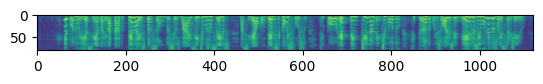

In [67]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

Side note: If you find this spectrogram confusing, it may be due to your familiarity with the convention of placing low frequencies at the bottom and high frequencies at the top of a plot. However, when plotting spectrograms as an image using the matplotlib library, the y-axis is flipped and the spectrograms appear upside down.

Now we need to apply the processing function to the entire dataset. This will take between 5 and 10 minutes.

In [68]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/16601 [00:00<?, ? examples/s]

You’ll see a warning saying that some examples in the dataset are longer than the maximum input length the model can handle (600 tokens). Remove those examples from the dataset. Here we go even further and to allow for larger batch sizes we remove anything over 200 tokens.

In [69]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/16601 [00:00<?, ? examples/s]

9126

Next, create a basic train/test split:

In [70]:
dataset = dataset.train_test_split(test_size=0.1)

**Data collator**

In order to combine multiple examples into a batch, you need to define a custom data collator. This collator will pad shorter sequences with padding tokens, ensuring that all examples have the same length. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value instructs the model to ignore that part of the spectrogram when calculating the spectrogram loss.

In [71]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [72]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

**Train the model**

Load the pre-trained model from the same checkpoint as you used for loading the processor:

In [73]:
from transformers import SpeechT5ForTextToSpeech
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

The *use_cache=True* option is incompatible with gradient checkpointing. Disable it for training, and re-enable cache for generation to speed-up inference time:

In [74]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

Define the training arguments. Here we are not computing any evaluation metrics during the training process, we’ll talk about evaluation later in this chapter. Instead, we’ll only look at the loss:

In [76]:
#!pip install transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [3]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_librispeech_pt",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

TypeError: Seq2SeqTrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

Instantiate the Trainer object and pass the model, dataset, and data collator to it.

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

And with that, we’re ready to start training! Training will take several hours. Depending on your GPU, it is possible that you will encounter a CUDA “out-of-memory” error when you start training. In this case, you can reduce the per_device_train_batch_size incrementally by factors of 2 and increase gradient_accumulation_steps by 2x to compensate.

In [ ]:
trainer.train()

Push the final model to the 🤗 Hub:

In [ ]:
trainer.push_to_hub()

**Inference**

Once you have fine-tuned a model, you can use it for inference! Load the model from the 🤗 Hub (make sure to use your account name in the following code snippet):

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "rlimonta/speecht5_finetuned_librispeech_pt"
)

Pick an example, here we’ll take one from the test dataset. Obtain a speaker embedding.

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

Define some input text and tokenize it.

In [ ]:
text = "Olá, seja bem vindo ao Portal de Inteligência Artificial!"

Preprocess the input text:

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Instantiate a vocoder and generate speech:

In [ ]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

Ready to listen to the result?

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

Obtaining satisfactory results from this model on a new language can be challenging. The quality of the speaker embeddings can be a significant factor. Since SpeechT5 was pre-trained with English x-vectors, it performs best when using English speaker embeddings. If the synthesized speech sounds poor, try using a different speaker embedding.

Increasing the training duration is also likely to enhance the quality of the results. Even so, the speech clearly is Dutch instead of English, and it does capture the voice characteristics of the speaker (compare to the original audio in the example). Another thing to experiment with is the model’s configuration. For example, try using config.reduction_factor = 1 to see if this improves the results.

In the next section, we’ll talk about how we evaluate text-to-speech models.